# Description

This notebook first calculates the Bayesian posterior distribution of the binomial single trial success probability, given the number of conducted tests ```n_trials_A``` and the number of successful tests ```n_successes_A``` out of these in a first experiment (A), using a uniform prior distribution. It then calculates the distribution of successes in a second experiment (B) with ```n_trials_B``` trials by using a binomial conditional distribution and the previously calculated distribution for the single trial success probability to calculate the unconditional distribution for the number of successes in the second experiment (B).

This notebook tells you how many successes to expect from a test with ```n_trials_B``` trials if you had previously conducted a test of the same system with ```n_trials_A``` trials of which ```n_successes_A``` were successful. It does so by first calculating a distribution for the possible single trial success probabilities your system might possess from the result of your experiment (A), and them using that information to calculate the probabilities for the possible outcomes of your test (B). This result depends on a so-called prior distribution that models your belief in different possible single trial success probabilities before test (A). By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [1]:
n_trials_A = 10
n_successes_A = 5

n_trials_B = 10

assert isinstance(n_trials_A, int) and n_trials_A > 0
assert isinstance(n_trials_B, int) and n_trials_B > 0
assert isinstance(n_successes_A, int) and 0 <= n_successes_A <= n_trials_A

# Evaluation

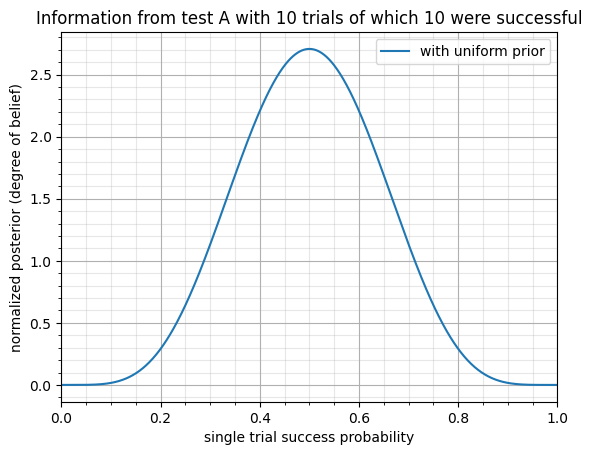

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_binom_p(p, n_trials_A, n_successes_A, prior):
    return mp.power(mp.mpf(p), n_successes_A) * mp.power(mp.mpf(1-p), (n_trials_A-n_successes_A)) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p_norm(n_trials_A, n_successes_A, prior, bounds):
    mean = (n_successes_A+1) / (n_trials_A+1)
    std_dev = ( (n_successes_A+1)*(n_trials_A-n_successes_A+1) / ((n_trials_A+1)**2*(n_trials_A+2)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials_A, n_successes_A, prior)
    prior_prescaled = lambda p: prior(p) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials_A, n_successes_A, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials_A, n_successes_A, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials_A, n_successes_A, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials_A, n_successes_A, prior_prescaled))[0]
        
    return norm / prescale

xlim_lo = 0.0 #change plot range here
xlim_hi = 1.0
p = np.linspace(xlim_lo, xlim_hi, 1001)

prior = lambda p: 1
norm_posterior = integrate_posterior_prob_binom_p_norm(n_trials_A, n_successes_A, prior, [0, 1])
posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials_A, n_successes_A, prior) / norm_posterior
plt.plot(p, posterior_probs, label='with uniform prior')

# prior = lambda p: (p*(1-p))**0.5
# norm_posterior = integrate_posterior_prob_binom_p_norm(n_trials_A, n_successes_A, prior, [0, 1])
# posterior_probs = posterior_prob_binom_p_vectorized(p, n_trials_A, n_trials_A, prior) / norm_posterior
# plt.plot(p, posterior_probs, label='with Jeffrey\'s prior')
# plt.plot(p, prior(p), label='Jeffrey\'s prior')

plt.gca().set_title('Information from test A with {} trials of which {} were successful'.format(n_trials_A, n_trials_A))
plt.gca().set_xlabel('single trial success probability')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([xlim_lo, xlim_hi]); #change plot range here

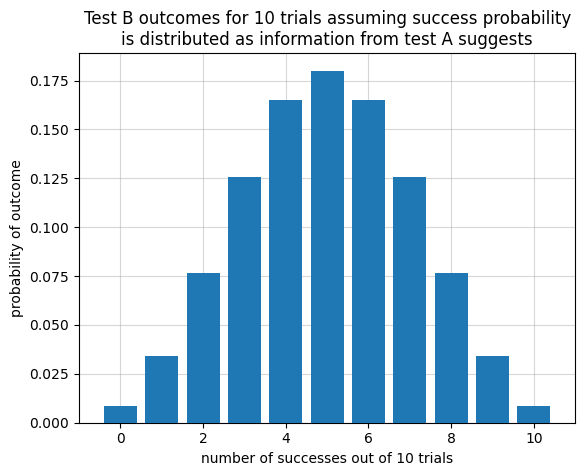

In [3]:
def conditional_distr(n_successes, p_success, n_trials):
    return mp.binomial(n_trials, n_successes) * mp.power(mp.mpf(p_success), n_successes) * mp.power(mp.mpf(1-p_success), (n_trials-n_successes))

conditional_distr_vectorized = np.vectorize(conditional_distr) #create version of binomial distribution that can be evaluated for whole lists of inputs

def unconditional_distr(n_successes_B, n_trials_B, n_trials_A, n_successes_A, prior, norm_posterior):
    mean = (n_successes_A+1) / (n_trials_A+1)
    std_dev = ( mp.mpf(int(n_successes_A+1))*mp.mpf(int(n_trials_A-n_successes_A+1)) / (mp.mpf(int(n_trials_A+1))**2*mp.mpf(int(n_trials_A+2))) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials_A, n_successes_A, prior)
    prior_prescaled = lambda p: prior(p) * prescale

    integrand = lambda p: posterior_prob_binom_p(p, n_trials_A, n_successes_A, prior_prescaled) * conditional_distr(n_successes_B, p, n_trials_B)
    bounds = [0, 1]
    
    int_value = 0
    if bounds[0] < mean-3*std_dev:
        int_value += integrate.quad(integrand, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        int_value += integrate.quad(integrand, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        int_value += integrate.quad(integrand, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        int_value += integrate.quad(integrand, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]))[0]
        
    return int_value / prescale / norm_posterior

unconditional_distr_vectorized = np.vectorize(unconditional_distr)

x = np.arange(0, n_trials_B+1) #list of all possible outcomes (number of successes x out of n_trials)
P_x = unconditional_distr_vectorized(x, n_trials_B, n_trials_A, n_successes_A, prior, norm_posterior) #probabilities of each of these outcomes

#plot
plt.bar(x, P_x, zorder=3)

plt.gca().set_title('Test B outcomes for {} trials assuming success probability\nis distributed as information from test A suggests'.format(n_trials_B))
plt.gca().set_xlabel('number of successes out of {} trials'.format(n_trials_B))
plt.gca().set_ylabel('probability of outcome')
plt.grid(alpha=0.5);

plt.gca().set_xlim([-1, n_trials_B+1]); #change plot range here